<a href="https://colab.research.google.com/github/leandroaguazaco/data_science_portfolio/blob/main/Projects/04-Churn_Telco_Analysis/04_Churn_Telco_Analysis_02_Premodeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 align="center"> 4 - CHURN TELCO ANALYSIS </h1>

<div align="center">

  <img alt="Static Badge" src="https://img.shields.io/badge/active_project-true-blue">

</div>  

<h2 align="center"> 4.2 - Premodeling </h2>

<div align="center">

  <img alt="Static Badge" src="https://img.shields.io/badge/active_section-true-blue">

  <img alt="Static Badge" src="https://img.shields.io/badge/section_status-in progress-green">

</div>  

<object
data="https://img.shields.io/badge/contact-Felipe_Leandro_Aguazaco-blue?style=flat&link=https%3A%2F%2Fwww.linkedin.com%2Fin%2Ffelipe-leandro-aguazaco%2F">
</object>

## a. Project summary

The aim of this project is to analyze and predict customer churn in the telco industry. The information pertains to client behavior, including in-call, out-call, and internet service consumption. There is a variable called 'Churn' that determines whether a customer churned within two weeks after canceling services. The information summarizes eight weeks of data for each telco line or client.

<h3 align="center"> <font color='orange'>NOTE: The project is distributed across multiple sections, separated into notebook files, in the following way:</font> </h3>



4.1 - Preprocessig data: load, join and clean data, and Exploratory data analysis, EDA.

> <font color='gray'> 4.2 - Premodeling: predict customer churn based on PyCaret library. </font> ✍ ▶ <font color='orange'> Current section </font>

4.3 - Modeling: predict customer churn based on sklearn pipelines.

4.4 - Analyzing and explaining predictions.

4.5 - Detecting vulneabilities in final machine learnig model.

4.6 - Model deployment with Streamlit.

## b. Install libraries

In [ ]:
%%capture
!pip install -U --pre pycaret
# !pip install --upgrade pycaret
!pip install pycaret[tuners]
!pip install pycaret[analysis]
!pip install shap==0.39.0
!pip install rpy2==3.5.1 # Use R
!pip install colorama

## c. Import libraries

In [2]:
%%capture
# c.1 Python Utilies
import pandas as pd
import numpy as np
import rpy2
import shutil
from google.colab import drive
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from colorama import Fore, Style
import shap

In [3]:
# c.2 PyCaret
from pycaret.classification import *
from pycaret.regression import *

In [4]:
# c.3 Setups
%matplotlib inline
plt.style.use("ggplot")
warnings.simplefilter("ignore")

## d. Custom functions

### d.1 - Type conversions

In [5]:
# d.1 dtypes conversion and memory reduce function.
def dtype_conversion(df: pd.DataFrame = None, verbose: bool = True)-> pd.DataFrame:
    """
    Summary:
      Function to dtypes conversion and save reduce memory usage; takes a DataFrame as argument, returns DataFrame.
      For more details, visit: https://towardsdatascience.com/how-to-work-with-million-row-datasets-like-a-pro-76fb5c381cdd.
      The modifications include type casting for numerical and object variables.
    Parameters:
      df (pandas.DataFrame): DataFrame containing information.
      verbose (bool, default = True): If true, display results (conversions and warnings)
    Returns:
      pandas.DataFrame: original DataFrame with dtypes conversions
      Plot original dtypes status, variable warning due high cardinality, save memory usage, final dtypes status.
    """
    # 0- Original dtypes
    # print(Fore.GREEN + "Input dtypes" + Style.RESET_ALL)
    # print(df.dtypes)
    # print("\n")
    print(Fore.RED + "Higha Cardinality, categorical features with levels > 15" + Style.RESET_ALL)

    # 1- Original memory_usage in MB
    start_mem = df.memory_usage().sum() / 1024 ** 2

    # 2- Numerical Types
    numerics = ["int8", "int16", "int32", "int64", "float16", "float32", "float64"]
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int": # First 3 characters
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if (c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max):
                    df[col] = df[col].astype(np.float32)
                #elif (c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max):
                #    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    # 3- Categorical Types
    high_card_vars = 0
    for col in df.select_dtypes(exclude = ["int8", "int16", "int32", "int64", "float16", "float32", "float64", "datetime64[ns]"]):
        categories = list(df[col].unique())
        cat_len = len(categories)
        if cat_len >= 2 and cat_len < 15:
           df[col] = df[col].astype("category")
        else:
          high_card_vars =+ 1
          # Print hight cardinality variables, amount of levels and a sample of 50 firts categories
          print(f"Look at: {Fore.RED + col + Style.RESET_ALL}, {cat_len} levels = {categories[:50]}")
    if high_card_vars == 0:
      print(Fore.GREEN + "None" + Style.RESET_ALL)
    else:
      pass

    # 4- Final memory_usage in MB
    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print("\n")
        print(f"{Fore.RED}Initial memory usage: {start_mem:.2f} MB{Style.RESET_ALL}")
        print(f"{Fore.BLUE}Memory usage decreased to {end_mem:.2f} MB ({ 100 * (start_mem - end_mem) / start_mem:.1f}% reduction){Style.RESET_ALL}")
        #print("\n")
        #print(Fore.GREEN + "Output dtypes" + Style.RESET_ALL)
        #print(df.dtypes)
        print("\n")

    # 5. Feature types
    print(Fore.GREEN + "Variable types" + Style.RESET_ALL)
    numerical_vars = len(df.select_dtypes(include = ["number"]).columns)
    categorical_vars = len(df.select_dtypes(include = ["category", "object"]).columns)
    datetime_vars = len(df.select_dtypes(include = ["datetime64[ns]"]).columns)
    print(f"Numerical Features: {numerical_vars}")
    print(f"Categorical Features: {categorical_vars}")
    print(f"Datetime Features: {datetime_vars}")

    return df

## 1 - Data

### 1.1 - Import from Google Drive

In [6]:
# Mount Google Drive
drive.mount('/content/drive')


# Specify the source path in Google Drive
drive_filepath = '/content/drive/MyDrive/DataScience_Portfolio/04-Churn_Telco_Analysis/'

# Specify the destination path in Colab
colab_filepath = '/content/'

# Copy the file from Google Drive to Colab
try:
  shutil.copy(src = drive_filepath + '/churn_data.txt', dst = colab_filepath + '/churn_data.txt')
except:
  pass

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 1.2 - Load data

In [7]:
churn_df = pd.read_csv(filepath_or_buffer = "churn_data.txt",
                       sep = "|",
                       index_col = "SUBSCRIBER_ID",
                       parse_dates = True,
                       decimal = ".",
                       encoding = "utf-8") \
             .assign(region = lambda x: x.loc[:, "region"].astype("category")) \
             .pipe(dtype_conversion) \
             .dropna(subset = ["churn"]) \
             .reset_index(drop = True)

# Security copy
churn_df_copy = churn_df.copy(deep = True)

Higha Cardinality, categorical features with levels > 15
Look at: region, 34 levels = ['Bogota D.C.', 'Santander', 'Antioquia', nan, 'Cundinamarca', 'Quindio', 'Valle Del Cauca', 'Arauca', 'Bolivar', 'Atlantico', 'Tolima', 'Huila', 'Meta', 'Putumayo', 'Boyaca', 'Caldas', 'Cordoba', 'Nariño', 'Magdalena', 'Risaralda', 'Cauca', 'La Guajira', 'Norte De Santander', 'Caqueta', 'Cesar', 'Guaviare', 'Sucre', 'Amazonas', 'Guainia', 'Vichada', 'Choco', 'Casanare', 'Providencia Islas', 'Vaupes']


Initial memory usage: 196.19 MB
Memory usage decreased to 92.12 MB (53.0% reduction)


Variable types
Numerical Features: 38
Categorical Features: 5
Datetime Features: 0


## 2 - Predicting Customer Churn

Pycaret
>[Home - Pycaret](https://pycaret.org/)

>[Read the docs - Pycaret](https://pycaret.readthedocs.io/en/stable/index.html)

### 2.1 - Init setup

In [10]:
%%time

# 2.1 Init the experimentation class
churn_binaryclass = ClassificationExperiment()

# 2.2 Init setup

churn_binaryclass.setup(data = churn_df,
                        target = 'churn', # Target column in data
                        index = False, # Hold original index
                        session_id = 123,
                        preprocess = True,
                        verbose = True, # When set to False, Information grid is not printed.
                        train_size = 0.75, # Proportion of the dataset to be used for training and validation
                        test_data = None,

                        # Dtypes categorical features
                        ordinal_features = None,
                        categorical_features = ["canal", "region", 'bandas', 'tipo_gross_adds'],
                        max_encoding_ohe = 30, # Categorical columns with max_encoding_ohe or less unique values are encoded using OneHotEncoding
                        rare_to_value = 0.05, # Minimum fraction of category occurrences in a categorical column
                        rare_value = "Otro", # Value with which to replace rare categories

                        # Dtypes numerical features
                        numeric_features = list(churn_df.select_dtypes(include = 'number').columns),

                        # Dtypes datetime features
                        date_features = None,
                        create_date_columns = ["day", "month", "year"], # Columns to create from the date features

                        # Normalize data: depending on similarity of numerical variables scales
                        normalize = True,
                        normalize_method = "robust", # z-score, minmax, maxabs, robust

                        # Transform data: depending on skewnees, kurtosis, outiler presence
                        transformation = True,
                        transformation_method = "yeo-johnson",

                        # Handled missing values
                        imputation_type = "iterative",
                        iterative_imputation_iters = 5,
                        numeric_iterative_imputer = "lightgbm", #"lightgbm", # Default method
                        categorical_iterative_imputer = "lightgbm", # Default method

                        # Outliers
                        remove_outliers = False,
                        outliers_method = "ee", # "iforest": Uses sklearn’s IsolationForest; "ee": Uses sklearn’s EllipticEnvelope; "lof": Uses sklearn’s LocalOutlierFactor
                        outliers_threshold = 0.05, # Percentage of outliers to be removed from the dataset

                        # Imbalance data: depending on levels distributions in target variable
                        fix_imbalance = True, # Dataset has unequal distribution of target class it can be balanced using this parameter
                        fix_imbalance_method = 'SMOTE', # Synthetic Minority Over-sampling Technique, choose from the name of an imblearn estimator

                        # Feature selection
                        feature_selection = True,
                        feature_selection_method = "univariate", # "sequential": uses sklearn's SequentialFeatureSelector, "classic": uses sklearn's SelectFromModel
                        feature_selection_estimator = "lightgbm", # Classifier used to determine the feature importance
                        n_features_to_select = 0.5, # The maximum number of features to select with feature_selection
                        low_variance_threshold = 0.1, # Remove features with a training-set variance lower than the provided threshold
                        pca = False,

                        # Multicollinearity
                        remove_multicollinearity = True, # Features with the inter-correlations higher than the defined threshold are removed
                        multicollinearity_threshold = 0.85, # Minimum absolute Pearson correlation to identify correlated features
                        #remove_perfect_collinearity = True,

                        # Cross validation stragery
                        data_split_shuffle = True,
                        data_split_stratify = True, # Controls stratification during train_test_split
                        fold_strategy = "stratifiedkfold",
                        fold = 5, # Number of folds to be used in cross validation, use in tuning hyperparameters

                        # Experiment Logging - Mlflow
                        #experiment_name = "Predicting NPS Type - v0.1",
                        #log_experiment = True,
                        #log_plots = True
)

,Description,Value
0,Session id,123
1,Target,churn
2,Target type,Binary
3,Target mapping,"No: 0, Sí: 1"
4,Original data shape,"(595663, 43)"
5,Transformed data shape,"(1012800, 22)"
6,Transformed train set shape,"(863884, 22)"
7,Transformed test set shape,"(148916, 22)"
8,Numeric features,38
9,Categorical features,4


CPU times: user 1min 16s, sys: 12.7 s, total: 1min 28s
Wall time: 1min 39s


### 2.2 - Check init setup results

In [ ]:
# 2.2. Access all the variables created by the setup function, check all available config

churn_binaryclass.get_config()
churn_binaryclass.get_config("pipeline")
# churn_binaryclass.get_config("_ml_usecase")
# churn_binaryclass.get_config("is_multiclass")



# churn_binaryclass.get_config("X_train")
# churn_binaryclass.get_config("y_train")
# churn_binaryclass.get_config("X_train_transformed")
# churn_binaryclass.get_config("y_train_transformed").value_counts()

# churn_binaryclass.get_config("X_test")
# churn_binaryclass.get_config("y_test")
# churn_binaryclass.get_config("X_test_transformed")
# churn_binaryclass.get_config("y_test_transformed")

Pipeline(memory=FastMemory(location=/tmp/joblib),
         steps=[('label_encoding',
                 TransformerWrapperWithInverse(exclude=None, include=None,
                                               transformer=LabelEncoder())),
                ('iterative_imputer',
                 TransformerWrapper(exclude=None, include=None,
                                    transformer=IterativeImputer(add_indicator=False,
                                                                 cat_estimator=LGBMClassifier(boosting_type='gbdt',
                                                                                              class_weight=None,
                                                                                              colsampl...
                                                                                         random_state=None,
                                                                                         reg_alpha=0.0,
                                                                                         reg_lambda=0.0,
                                                                                         silent='warn',
                                                                                         subsample=1.0,
                                                                                         subsample_for_bin=200000,
                                                                                         subsample_freq=0),
                                                                importance_getter='auto',
                                                                max_features=21,
                                                                norm_order=1,
                                                                prefit=False,
                                                                threshold=-inf))),
                ('clean_column_names',
                 TransformerWrapper(exclude=None, include=None,
                                    transformer=CleanColumnNames(match='[\\]\\[\\,\\{\\}\\"\\:]+')))],
         verbose=False)

In [ ]:
# PyCaret Models
churn_binaryclass.models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


### 2.3 - Compare and select models

In [11]:
# 2.3 Compare models: metrics are calculated using cross-validation on the training set
best_models = churn_binaryclass.compare_models(sort = "Recall",
                                               n_select = 1,
                                               turbo = True,
                                               budget_time = None,
                                               cross_validation = True,
                                               # include = ['lr', 'nb', 'xgboost', 'lightgbm', 'ada', 'rf']
                                               include = ['lightgbm'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9643,0.6647,0.1416,0.3944,0.2082,0.1941,0.2213,116.9680


Processing:   0%|          | 0/9 [00:00<?, ?it/s]

### 2.4 - Analyze models

In [10]:
# 1. Results plots, no tuned model: metrics are calculated on the test set

sns.set_palette(palette = "viridis") # Viridis pallete
churn_binaryclass.evaluate_model(best_models, plot_kwargs = {'cmap': sns.color_palette('viridis')})

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

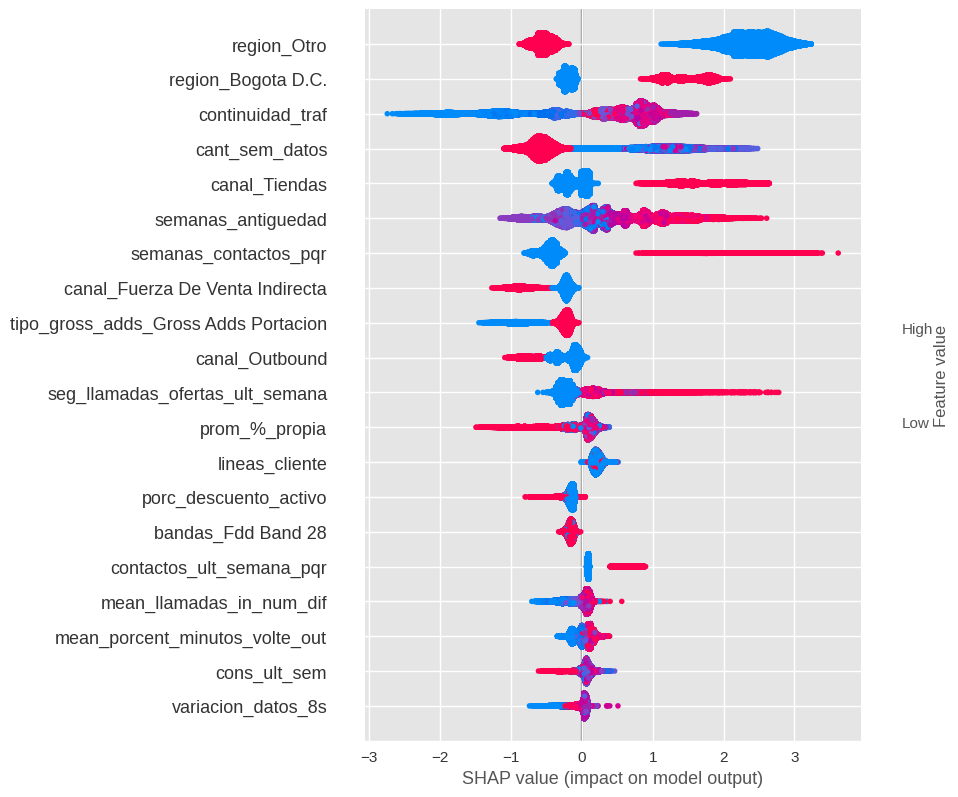

In [11]:
# 2. Interpret Model
# Implemented based on the SHAP (Shapley Additive exPlanations)
# https://shap.readthedocs.io/en/latest/

plt.rcParams['image.cmap'] = 'viridis'
churn_binaryclass.interpret_model(best_models, plot = 'summary')

### 2.5 - Predictions

In [12]:
# Predictions
# Model 1: Light Gradient Boosting Machine

# Model's hyperparameters
print(best_models)
print("\n")

# Testing dataset
test_data = pd.concat([churn_binaryclass.get_config("X_test")]) \
              .loc[:, list(churn_binaryclass.get_config("X_train").columns)]

# Calculate predictions
churn_binaryclass.predict_model(best_models,
                                data = test_data,
                                raw_score = True)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=123, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)




,cant_sem_datos,prom_gb_tt,prom_gb_ran,prom_%_propia,continuidad_traf,variacion_datos_8s,cons_ult_sem,contrafico,mean_minutos_voz_in,mean_llamadas_in,...,semanas_antiguedad,semanas_contactos_pqr,contactos_ult_semana_pqr,seg_llamadas_ofertas_ult_semana,var_seg_llamadas_ofertas_4_semanas,porc_descuento_activo,jineteo,prediction_label,prediction_score_No,prediction_score_Sí
0,7.0,3.808,0.747,0.828,1.000,-27.070999,2.777,1,8.334000,5.143,...,7.0,0.0,0.0,9.0,0.000,0.0,1.0,Sí,0.0068,0.9932
1,8.0,2.322,0.048,0.979,0.400,-41.863998,1.350,1,115.051003,26.375,...,20.0,0.0,0.0,0.0,0.000,1.0,1.0,Sí,0.0616,0.9384
2,8.0,13.562,0.257,0.979,0.800,-4.881000,12.900,1,50.827999,16.500,...,10.0,0.0,0.0,20.0,-0.091,0.0,1.0,Sí,0.0323,0.9677
3,8.0,0.476,0.129,0.643,0.471,-34.949001,0.310,1,46.019001,25.125,...,17.0,0.0,0.0,0.0,0.000,0.0,1.0,Sí,0.0027,0.9973
4,8.0,2.627,0.036,0.983,0.364,-21.343000,2.067,1,9.565000,7.000,...,22.0,0.0,0.0,174.0,0.184,1.0,1.0,Sí,0.0043,0.9957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148911,8.0,0.145,0.004,0.971,0.727,21.056999,0.175,1,60.820999,23.375,...,11.0,0.0,0.0,152.0,-0.707,0.0,1.0,Sí,0.0044,0.9956
148912,4.0,4.426,0.023,0.993,1.333,-18.914000,3.589,1,52.730000,13.750,...,3.0,0.0,0.0,0.0,0.000,0.0,1.0,Sí,0.0008,0.9992
148913,8.0,3.240,1.562,0.321,0.500,-72.109001,0.904,1,7.332000,8.500,...,16.0,0.0,0.0,0.0,0.000,0.0,1.0,No,0.8079,0.1921
148914,8.0,3.098,0.192,0.923,0.267,23.360001,3.821,1,19.160999,13.750,...,30.0,0.0,0.0,0.0,0.000,1.0,1.0,Sí,0.0052,0.9948


### 2.6 -  Hyperparameters tuning

In [ ]:
# Hyperparameters tuning

# lightgbmClassifier
tuned_lightgbm = churn_binaryclass.tune_model(estimator = best_models,
                                              optimize = "Recall",
                                              n_iter = 5,
                                              search_library = "scikit-optimize",
                                              search_algorithm = "bayesian")
print("\n")
print(tuned_lightgbm)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,00:22:37
Status,. . . . . . . . . . . . . . . . . .,Finalizing Model
Estimator,. . . . . . . . . . . . . . . . . .,Light Gradient Boosting Machine


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


### 2.7 - Save and load models

In [ ]:
# Save models: create pickle file

# lightgbmClassifier
churn_binaryclass.save_model(model = tuned_lightgbm, model_name = 'LightgbmClassifier_model_churn')

In [ ]:
# Load the model back in environment
lightgbm_model_tuned = load_model('LightgbmClassifier_model_churn')

### 2.8 - Save / Load Experiment

In [ ]:
# 1. Save experiment
churn_binaryclass.save_experiment("churn_binaryclass_experiment")

In [ ]:
# 10. 2 Load experiment from disk
churn_binaryclass2 = load_experiment(path_or_file = 'churn_binaryclass_experiment',
                                     data = churn_df) # From step 1